# ESIEE Paris — Data Engineering I — Assignment 3
> Author : Couzinet Lorenzo & Rabahi Enzo 

**Academic year:** 2025–2026  
**Program:** Data & Applications - Engineering - (FD)   
**Course:** Data Engineering I  

---

## Learning goals
- Analyze with **SQL** and **DataFrames**.
- Implement two **RDD means** variants.
- Implement **RDD joins** (shuffle and hash).
- Record and explain performance observations.


## 1. Setup

Download data files from the following URL:
https://www.dropbox.com/scl/fi/7012u693u06dgj95mgq2a/retail_dw_20250826.tar.gz?rlkey=fxyozuoryn951gzwmli5xi2zd&dl=0

Unpack somewhere and define the `data_path` accordingly:

In [6]:
# Change to path on your local machine.
data_path = "/Users/lorenzo/Documents/Cours/E4FD/Data-Engineering/Lab3/lab3Assignment/retail_dw_20250826"

The following cell contains setup to measure wall clock time and memory usage. (Don't worry about the details, just run the cell)

In [7]:
# !pip install -U numpy pandas pyarrow matplotlib scipy
import sys, subprocess
try:
    import psutil  # noqa: F401
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "psutil"])
print("psutil is installed.")


from IPython.core.magic import register_cell_magic
import time, os, platform

# Try to import optional modules
try:
    import psutil
except Exception:
    psutil = None

try:
    import resource  # not available on Windows
except Exception:
    resource = None


def _rss_bytes():
    """Resident Set Size in bytes (cross-platform via psutil if available)."""
    if psutil is not None:
        return psutil.Process(os.getpid()).memory_info().rss
    # Fallback: unknown RSS → 0 
    return 0


def _peak_bytes():
    """
    Best-effort peak memory in bytes.
    - Windows: psutil peak working set (peak_wset)
    - Linux:   resource.ru_maxrss (KB → bytes)
    - macOS:   resource.ru_maxrss (bytes)
    Fallback to current RSS if unavailable.
    """
    sysname = platform.system()

    # Windows path: use psutil peak_wset if present
    if sysname == "Windows" and psutil is not None:
        mi = psutil.Process(os.getpid()).memory_info()
        peak = getattr(mi, "peak_wset", None)  # should be available on Windows
        if peak is not None:
            return int(peak)
        return int(mi.rss)

    # POSIX path: resource may be available
    if resource is not None:
        try:
            ru = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
            # On Linux ru_maxrss is in kilobytes; on macOS/BSD it is bytes
            if sysname == "Linux":
                return int(ru) * 1024
            else:
                return int(ru)
        except Exception:
            pass

    # Last resort
    return _rss_bytes()


@register_cell_magic
def timemem(line, cell):
    """
    Measure wall time and memory around the execution of this cell.

        %%timemem
        <your code>

    Notes:
    - RSS = resident memory after the cell.
    - Peak is OS-dependent (see _peak_bytes docstring).
    """
    ip = get_ipython()

    rss_before  = _rss_bytes()
    peak_before = _peak_bytes()
    t0 = time.perf_counter()

    # Execute the cell body
    result = ip.run_cell(cell)

    t1 = time.perf_counter()
    rss_after  = _rss_bytes()
    peak_after = _peak_bytes()

    wall = t1 - t0
    rss_delta_mb  = (rss_after  - rss_before)  / (1024 * 1024)
    peak_delta_mb = (peak_after - peak_before) / (1024 * 1024)

    print("======================================")
    print(f"Wall time: {wall:.3f} s")
    print(f"RSS Δ: {rss_delta_mb:+.2f} MB")
    print(f"Peak memory Δ: {peak_delta_mb:+.2f} MB (OS-dependent)")
    print("======================================")

    return result

psutil is installed.


The following code snippet should "just work" to initialize Spark.

In [8]:
import findspark, os

# Change to path on your local machine.
os.environ["SPARK_HOME"] = "/Users/lorenzo/miniconda3/envs/de1-env/lib/python3.11/site-packages/pyspark"
findspark.init()

from pyspark.sql import SparkSession, functions as F, Window
from pyspark.sql.functions import broadcast

py = sys.executable  # the Python of this notebook (e.g., .../envs/yourenv/bin/python)
os.environ["PYSPARK_DRIVER_PYTHON"] = py
os.environ["PYSPARK_PYTHON"] = py

spark = SparkSession.getActiveSession() or (
    SparkSession.builder
    .appName("A3")
    .master("local[*]")
    .config("spark.driver.memory", "8g")           
    .config("spark.sql.shuffle.partitions","400")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.pyspark.driver.python", py)
    .config("spark.pyspark.python", py)
    .config("spark.executorEnv.PYSPARK_PYTHON", py)
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")

sc = spark.sparkContext
print("Spark:", spark.version)

Spark: 4.0.1


## 2. Loading DataFrames

Let's load the DataFrames and print out their schemas:

In [9]:
# Note that you should have defined data_path above

events_df   = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_events"))
products_df = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_products"))
brands_df   = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_brands"))

events_df.printSchema()
products_df.printSchema()
brands_df.printSchema()

root
 |-- date_key: integer (nullable = true)
 |-- user_key: integer (nullable = true)
 |-- age_key: integer (nullable = true)
 |-- product_key: integer (nullable = true)
 |-- brand_key: integer (nullable = true)
 |-- category_key: integer (nullable = true)
 |-- session_id: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- price: double (nullable = true)

root
 |-- category_code: string (nullable = true)
 |-- brand_code: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- product_desc: string (nullable = true)
 |-- brand_key: integer (nullable = true)
 |-- category_key: integer (nullable = true)
 |-- product_key: integer (nullable = true)

root
 |-- brand_code: string (nullable = true)
 |-- brand_desc: string (nullable = true)
 |-- brand_key: integer (nullable = true)



How many rows are in each table?

In [10]:
print(f"Number of rows in events   table: {events_df.count()}")
print(f"Number of rows in products table: {products_df.count()}")
print(f"Number of rows in brands   table: {brands_df.count()}")

Number of rows in events   table: 42351862
Number of rows in products table: 166794
Number of rows in brands   table: 3444


We can register the DataFrames as tables and issue SQL queries:

In [11]:
events_df.createOrReplaceTempView("events")
products_df.createOrReplaceTempView("products")
brands_df.createOrReplaceTempView("brands")

spark.sql('select count(*) from events').show()
spark.sql('select count(*) from products').show()
spark.sql('select count(*) from brands').show()

+--------+
|count(1)|
+--------+
|42351862|
+--------+

+--------+
|count(1)|
+--------+
|  166794|
+--------+

+--------+
|count(1)|
+--------+
|    3444|
+--------+



As a sanity check, the corresponding values should match: counting the rows in the DataFrame vs. issuing an SQL query to count the number of rows.

## 3. Data Science

Answer Q1 to Q7 below with SQL queries and DataFrame manipulations.

**write some code here**

### 3.1 Q1

For session_id `789d3699-028e-4367-b515-b82e2cb5225f`, what was the purchase price?

**Hint:** We only care about purchase events.

First, do it using SQL:

In [12]:
%%timemem
# codecell_31a (keep this id for tracking purposes)

# Write your SQL below
sql_query = """
SELECT price
FROM events
WHERE session_id = '789d3699-028e-4367-b515-b82e2cb5225f'
  AND event_type = 'purchase'
"""

results = spark.sql(sql_query)

results.show()

+------+
| price|
+------+
|100.39|
+------+

Wall time: 1.283 s
RSS Δ: -16.52 MB
Peak memory Δ: +0.03 MB (OS-dependent)


<ExecutionResult object at 107afaf10, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1073614d0, raw_cell="# codecell_31a (keep this id for tracking purposes.." transformed_cell="# codecell_31a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [13]:
%%timemem
# codecell_31b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.
results_df = events_df.filter(
    (F.col("session_id") == "789d3699-028e-4367-b515-b82e2cb5225f") & 
    (F.col("event_type") == "purchase")
).select("price")

results_df.show()

+------+
| price|
+------+
|100.39|
+------+

Wall time: 0.541 s
RSS Δ: +0.08 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 107b18410, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 103ddc210, raw_cell="# codecell_31b (keep this id for tracking purposes.." transformed_cell="# codecell_31b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.2 Q2

How many products are sold by the brand "sokolov"?

First, do it using SQL:

In [16]:
%%timemem
# codecell_32a (keep this id for tracking purposes)

# Write your SQL below
sql_query = """
SELECT count(*)
FROM events e
JOIN brands b ON e.brand_key = b.brand_key
WHERE b.brand_code = 'sokolov'
  AND e.event_type = 'purchase'
"""

results = spark.sql(sql_query)

results.show()

+--------+
|count(1)|
+--------+
|     925|
+--------+

Wall time: 0.693 s
RSS Δ: +0.02 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 107d82ed0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 107d82c50, raw_cell="# codecell_32a (keep this id for tracking purposes.." transformed_cell="# codecell_32a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [19]:
%%timemem
# codecell_32b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.
results_df = events_df.join(brands_df, "brand_key") \
    .filter((F.col("brand_code") == "sokolov") & (F.col("event_type") == "purchase")) \
    .agg(F.count("*").alias("count"))

results_df.show()

+-----+
|count|
+-----+
|  925|
+-----+

Wall time: 0.573 s
RSS Δ: +2.12 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 108211610, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 108211110, raw_cell="# codecell_32b (keep this id for tracking purposes.." transformed_cell="# codecell_32b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.3 Q3

What is the average purchase price of items purchased from the brand "febest"? (Report answer to two digits after the decimal point, i.e., XX.XX.)

First, do it using SQL:

In [21]:
%%timemem
# codecell_33a (keep this id for tracking purposes)

# Write your SQL below
sql_query = """
SELECT CAST(AVG(e.price) AS DECIMAL(10,2)) as avg_price
FROM events e
JOIN brands b ON e.brand_key = b.brand_key
WHERE b.brand_code = 'febest'
  AND e.event_type = 'purchase'
"""

results = spark.sql(sql_query)

results.show()

+---------+
|avg_price|
+---------+
|    20.39|
+---------+

Wall time: 1.009 s
RSS Δ: +0.08 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 108251550, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 108250e50, raw_cell="# codecell_33a (keep this id for tracking purposes.." transformed_cell="# codecell_33a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [22]:
%%timemem
# codecell_33b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.
results_df = events_df.join(brands_df, "brand_key") \
    .filter((F.col("brand_code") == "febest") & (F.col("event_type") == "purchase")) \
    .agg(F.round(F.avg("price"), 2).alias("avg_price"))


results_df.show()

+---------+
|avg_price|
+---------+
|    20.39|
+---------+

Wall time: 0.572 s
RSS Δ: +0.08 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 108233110, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1082323d0, raw_cell="# codecell_33b (keep this id for tracking purposes.." transformed_cell="# codecell_33b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.4 Q4

What is the average number of events per user? (Report answer to two digits after the decimal point, i.e., XX.XX.)

First, do it using SQL:

In [25]:
%%timemem
# codecell_34a (keep this id for tracking purposes)

# Write your SQL below
sql_query = """
SELECT CAST(COUNT(*) / COUNT(DISTINCT user_key) AS DECIMAL(10,2)) as avg_events_per_user
FROM events
"""

results = spark.sql(sql_query)

results.show()

+-------------------+
|avg_events_per_user|
+-------------------+
|              14.02|
+-------------------+

Wall time: 1.061 s
RSS Δ: +0.02 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 108212710, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 108212dd0, raw_cell="# codecell_34a (keep this id for tracking purposes.." transformed_cell="# codecell_34a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [27]:
%%timemem
# codecell_34b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

total_events = events_df.count()
# On utilise user_key car c'est un entier (plus rapide que user_id string)
total_users = events_df.select("user_key").distinct().count()

results_df = spark.createDataFrame([(round(total_events / total_users, 2),)], ["avg_events_per_user"])

results_df.show()

+-------------------+
|avg_events_per_user|
+-------------------+
|              14.02|
+-------------------+

Wall time: 2.048 s
RSS Δ: -10.45 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 108281a10, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1082815d0, raw_cell="# codecell_34b (keep this id for tracking purposes.." transformed_cell="# codecell_34b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.5 Q5

What are the top 10 (`product_name`, `brand_code`) pairs in terms of revenue? We want the answer rows sorted by revenue in descending order.

First, do it using SQL:

In [28]:
%%timemem
# codecell_35a (keep this id for tracking purposes)

# Write your SQL below

sql_query = """
SELECT p.product_name, b.brand_code, SUM(e.price) as revenue
FROM events e
JOIN products p ON e.product_key = p.product_key
JOIN brands b ON e.brand_key = b.brand_key
WHERE e.event_type = 'purchase'
GROUP BY p.product_name, b.brand_code
ORDER BY revenue DESC
LIMIT 10
"""

results = spark.sql(sql_query)

results.show()

+---------------+----------+--------------------+
|   product_name|brand_code|             revenue|
+---------------+----------+--------------------+
|     smartphone|     apple| 1.671134080299983E8|
|     smartphone|   samsung|  9.54662750799999E7|
|     smartphone|    xiaomi|2.2549726339999955E7|
|     smartphone|    huawei| 1.363398708999999E7|
|       video.tv|   samsung|1.2209992470000006E7|
|           NULL|   lucente|   9556989.319999998|
|       notebook|      acer|   8963128.649999993|
|         clocks|     apple|   8622900.639999997|
|audio.headphone|     apple|   7783503.129999984|
| kitchen.washer|   samsung|   5779978.030000006|
+---------------+----------+--------------------+

Wall time: 1.495 s
RSS Δ: -6.86 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 108189210, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1079bc4d0, raw_cell="# codecell_35a (keep this id for tracking purposes.." transformed_cell="# codecell_35a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [29]:
%%timemem
# codecell_35b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

products_clean = products_df.drop("brand_code")

results_df = events_df.filter(F.col("event_type") == "purchase") \
    .join(products_clean, "product_key") \
    .join(brands_df, "brand_key") \
    .groupBy("product_name", "brand_code") \
    .agg(F.sum("price").alias("revenue")) \
    .orderBy(F.col("revenue").desc()) \
    .limit(10)


results_df.show(truncate=False)

+---------------+----------+--------------------+
|product_name   |brand_code|revenue             |
+---------------+----------+--------------------+
|smartphone     |apple     |1.671134080299983E8 |
|smartphone     |samsung   |9.54662750799999E7  |
|smartphone     |xiaomi    |2.2549726339999955E7|
|smartphone     |huawei    |1.363398708999999E7 |
|video.tv       |samsung   |1.2209992470000006E7|
|NULL           |lucente   |9556989.319999998   |
|notebook       |acer      |8963128.649999993   |
|clocks         |apple     |8622900.639999997   |
|audio.headphone|apple     |7783503.129999984   |
|kitchen.washer |samsung   |5779978.030000006   |
+---------------+----------+--------------------+

Wall time: 0.908 s
RSS Δ: +1.20 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 107d81dd0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 107d820d0, raw_cell="# codecell_35b (keep this id for tracking purposes.." transformed_cell="# codecell_35b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.6 Q6

Tally up counts of events by hour.
More precisely, we want a table with hours 0, 1, ... 23 with the counts of events in that hour.

First, do it using SQL:

In [30]:
%%timemem
# codecell_36a (keep this id for tracking purposes)

# Write your SQL below

sql_query = """
SELECT HOUR(event_time) as hour, COUNT(*) as count
FROM events
GROUP BY HOUR(event_time)
ORDER BY hour ASC
"""

results = spark.sql(sql_query)

results.show(24)

+----+-------+
|hour|  count|
+----+-------+
|   0| 263808|
|   1| 223635|
|   2| 353509|
|   3| 623434|
|   4|1137209|
|   5|1605037|
|   6|1955461|
|   7|2131930|
|   8|2269469|
|   9|2332649|
|  10|2380185|
|  11|2335494|
|  12|2282992|
|  13|2181477|
|  14|2171196|
|  15|2407266|
|  16|2717710|
|  17|2988054|
|  18|3008559|
|  19|2631424|
|  20|1999466|
|  21|1244129|
|  22| 694728|
|  23| 413041|
+----+-------+

Wall time: 1.582 s
RSS Δ: -0.09 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 108282910, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 108283f10, raw_cell="# codecell_36a (keep this id for tracking purposes.." transformed_cell="# codecell_36a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [31]:
%%timemem
# codecell_36b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

events_by_hour_df = events_df.withColumn("hour", F.hour("event_time")) \
    .groupBy("hour") \
    .count() \
    .orderBy("hour")


events_by_hour_df.show(24)

+----+-------+
|hour|  count|
+----+-------+
|   0| 263808|
|   1| 223635|
|   2| 353509|
|   3| 623434|
|   4|1137209|
|   5|1605037|
|   6|1955461|
|   7|2131930|
|   8|2269469|
|   9|2332649|
|  10|2380185|
|  11|2335494|
|  12|2282992|
|  13|2181477|
|  14|2171196|
|  15|2407266|
|  16|2717710|
|  17|2988054|
|  18|3008559|
|  19|2631424|
|  20|1999466|
|  21|1244129|
|  22| 694728|
|  23| 413041|
+----+-------+

Wall time: 1.121 s
RSS Δ: +0.03 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 108221f10, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 108222390, raw_cell="# codecell_36b (keep this id for tracking purposes.." transformed_cell="# codecell_36b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

When you run the cell above, `events_by_hour_df` should be something like:

```
+----+-------+
|hour|  count|
+----+-------+
|   0|    ???|
|   1|    ???|
  ...
|  23|    ???|
+----+-------+
```

In [35]:
%pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 10.8 MB/s  0:00:00 eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 7.8 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 7.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


Now plot the above DataFrame using `matplotlib`.
Here we want a line graph, with hour on the _x_ axis and count on the _y_ axis.

**Hint:** use the code below to get started.

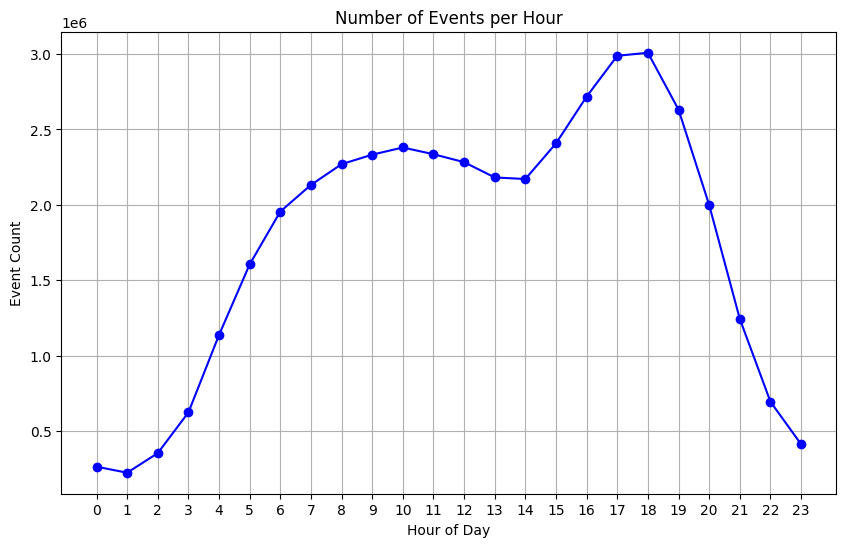

Wall time: 6.841 s
RSS Δ: +78.91 MB
Peak memory Δ: +22.77 MB (OS-dependent)


<ExecutionResult object at 108283450, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1082839d0, raw_cell="# codecell_36c (keep this id for tracking purposes.." transformed_cell="# codecell_36c (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [36]:
%%timemem
# codecell_36c (keep this id for tracking purposes)

import matplotlib.pyplot as plt

events_by_hour_pdf = events_by_hour_df.toPandas()

# TODO: Write your code below, but do not remove any lines already in this cell.

plt.figure(figsize=(10, 6))
plt.plot(events_by_hour_pdf['hour'], events_by_hour_pdf['count'], marker='o', color='b')
plt.title('Number of Events per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Event Count')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

### 3.7 Q7

We are going to analyze the "big" brands. Find out the average purchase price by brand, and restrict to cases where the average is more than 10K.
We want the results sorted by the average purchase price from the largest to smallest value.
(Report answers to two digits after the decimal point, i.e., XX.XX, but it's okay if the output only contains one digit after the decimal point.)

First, do it using SQL:

In [37]:
%%timemem
# codecell_37a (keep this id for tracking purposes)

# Write your SQL below

sql_query = """
SELECT b.brand_code, CAST(AVG(e.price) AS DECIMAL(10,2)) as avg_price
FROM events e
JOIN brands b ON e.brand_key = b.brand_key
WHERE e.event_type = 'purchase'
GROUP BY b.brand_code
HAVING AVG(e.price) > 10000
ORDER BY avg_price DESC
"""

results = spark.sql(sql_query)

results.show()

+----------+---------+
|brand_code|avg_price|
+----------+---------+
|      adam| 58946.00|
|      kona| 43759.00|
|  yuandong| 35329.00|
|   bentley| 23164.00|
|      otex| 18633.14|
|    suunto| 10732.82|
|     stark| 10400.25|
+----------+---------+

Wall time: 1.248 s
RSS Δ: +0.14 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 1082e2b90, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1082e3910, raw_cell="# codecell_37a (keep this id for tracking purposes.." transformed_cell="# codecell_37a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [39]:
%%timemem
# codecell_37b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

avg_price_by_brand_df = events_df.filter(F.col("event_type") == "purchase") \
    .join(brands_df, "brand_key") \
    .groupBy("brand_code") \
    .agg(F.avg("price").alias("avg_price")) \
    .filter(F.col("avg_price") > 10000) \
    .withColumn("avg_price", F.round("avg_price", 2)) \
    .orderBy(F.col("avg_price").desc())


avg_price_by_brand_df.show()

+----------+---------+
|brand_code|avg_price|
+----------+---------+
|      adam|  58946.0|
|      kona|  43759.0|
|  yuandong|  35329.0|
|   bentley|  23164.0|
|      otex| 18633.14|
|    suunto| 10732.82|
|     stark| 10400.25|
+----------+---------+

Wall time: 0.578 s
RSS Δ: +0.03 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 109519dd0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 10951afd0, raw_cell="# codecell_37b (keep this id for tracking purposes.." transformed_cell="# codecell_37b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

When you run the cell above, `avg_price_by_brand_df` should be something like:

```
+----------+------------------+
|brand_code|         avg_price|
+----------+------------------+
|       ???|               ???|
        ...
|       ???|               ???|
+----------+------------------+
```

Now plot the above DataFrame using `matplotlib`.
Here we want a bar chart, with each of the brands as a bar, and the average price on the _y_ axis.

**Hint:** use the code below to get started.

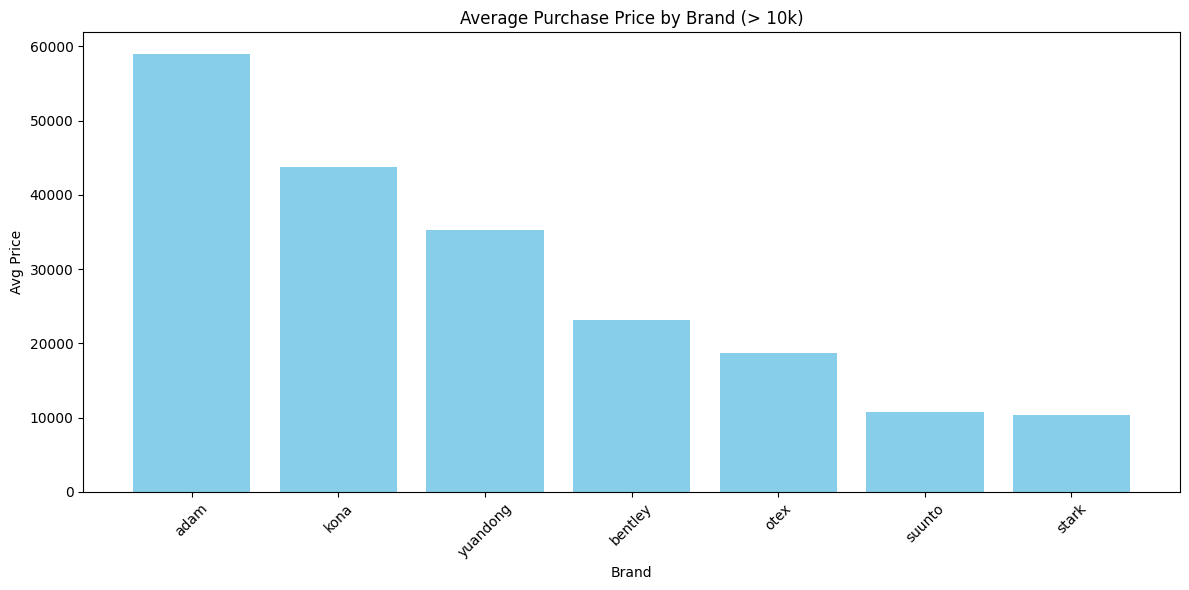

Wall time: 0.642 s
RSS Δ: +4.47 MB
Peak memory Δ: +4.08 MB (OS-dependent)


<ExecutionResult object at 1095291d0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 10952a390, raw_cell="# codecell_37c (keep this id for tracking purposes.." transformed_cell="# codecell_37c (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [40]:
%%timemem
# codecell_37c (keep this id for tracking purposes)

import matplotlib.pyplot as plt

avg_price_by_brand_pdf = avg_price_by_brand_df.toPandas()

# TODO: Write your code below, but do not remove any lines already in this cell.

plt.figure(figsize=(12, 6))
plt.bar(avg_price_by_brand_pdf['brand_code'], avg_price_by_brand_pdf['avg_price'], color='skyblue')
plt.title('Average Purchase Price by Brand (> 10k)')
plt.xlabel('Brand')
plt.ylabel('Avg Price')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## 4. Load RDDs

The remaining exercises focus on RDD manipulations.

Let's start by loading the RDDs.

In [41]:
# Get RDDs directly from DataFrames (with required repartitions)
# type: RDD[Row]
events_rdd   = events_df.rdd.repartition(1000)
products_rdd = products_df.rdd.repartition(100)
brands_rdd   = brands_df.rdd.repartition(100)

You'll need `Row`, so let's make sure we've imported it.

In [42]:
from pyspark.sql import Row

## 5. Implementations of Computing Averages

In this next exercise, we're going to implement "computing the mean" (version 1) and (version 3) in Spark as described in the second lecture **Batch Processing I** (please use ctrl+f to reach the slide with the title : "Computing the Mean: Version 1" or "Computing the Mean: Version 3".

To make the problem more tractable (i.e., to reduce the running times), let's first do a bit of filtering of the `events` table.
We'll do this using DataFrames, and then generate an RDD:

In [43]:
filtered_events_df = (
    events_df
        .filter((F.col("event_type") == "purchase") & F.col("price").isNotNull())
        .join(brands_df, on="brand_key")
)

filtered_events_df.count()

print(f"Number of rows in events          table: {events_df.count()}")
print(f"Number of rows in filtered events table: {filtered_events_df.count()}")

filtered_events_rdd = filtered_events_df.rdd

Number of rows in events          table: 42351862
Number of rows in filtered events table: 664885


You can confirm that we're working with a smaller dataset.

Compute the average purchase price by brand. We want the results sorted by the average purchase price from the largest to smallest value. As before, round to two digits after the decimal point. This is similar to Q7 above, except _without_ the "more than 10K" condition.

Implement using the naive **"version 1"** algorithm, as described in the lectures:

+ You _must_ start with `filtered_events_rdd`.
+ You _must_ use `groupByKey()`.
+ Per "version 1", your implementation _must_ shuffle all values from the "mappers" to the "reducers".

**write some code here**

In [45]:
%%timemem
# codecell_5x1 (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

# On convertit le prix en float pour être sûr
mapped_rdd_v1 = filtered_events_rdd.map(lambda row: (row['brand_code'], float(row['price'])))

# On regroupe tous les prix par marque 
grouped_rdd = mapped_rdd_v1.groupByKey()

# On convertit en liste pour avoir la taille
average_revenue_per_brand_v1 = grouped_rdd \
    .mapValues(lambda prices: list(prices)) \
    .mapValues(lambda prices_list: round(sum(prices_list) / len(prices_list), 2)) \
    .sortBy(lambda x: x[1], ascending=False)

average_revenue_per_brand_v1.take(10)

[('adam', 58946.0),
 ('kona', 43759.0),
 ('yuandong', 35329.0),
 ('bentley', 23164.0),
 ('otex', 18633.13),
 ('suunto', 10732.82),
 ('stark', 10400.25),
 ('zenmart', 9447.0),
 ('baltekstil', 8504.19),
 ('bugati', 8288.42)]

Wall time: 33.827 s
RSS Δ: -3.48 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 1096a3950, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1096a2250, raw_cell="# codecell_5x1 (keep this id for tracking purposes.." transformed_cell="# codecell_5x1 (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=[('adam', 58946.0), ('kona', 43759.0), ('yuandong', 35329.0), ('bentley', 23164.0), ('otex', 18633.13), ('suunto', 10732.82), ('stark', 10400.25), ('zenmart', 9447.0), ('baltekstil', 8504.19), ('bugati', 8288.42)]>

Compute the average purchase price by brand. We want the results sorted by the average purchase price from the largest to smallest value. As before, round to two digits after the decimal point. This is similar to Q7 above, except _without_ the "more than 10K" condition.

Implement using the improved **"version 3"** algorithm, as described in the lectures:

+ You _must_ start with `filtered_events_rdd`.
+ You _must_ use `reduceByKey()`.
+ Per "version 3", your implementation _must_ emit `(sum, count)` pairs and take advantage opportunities to perform aggregations.

**write some code here**

In [46]:
%%timemem
# codecell_5x2 (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

# On prépare le tuple (Somme, Compteur)
mapped_rdd_v3 = filtered_events_rdd.map(lambda row: (row['brand_code'], (float(row['price']), 1)))

# On somme les prix et les compteurs 
reduced_rdd = mapped_rdd_v3.reduceByKey(lambda acc, val: (acc[0] + val[0], acc[1] + val[1]))

# On divise la somme finale par le compteur total pour avoir la moyenne
average_revenue_per_brand_v3 = reduced_rdd \
    .mapValues(lambda x: round(x[0] / x[1], 2)) \
    .sortBy(lambda x: x[1], ascending=False)

average_revenue_per_brand_v3.take(10)

[('adam', 58946.0),
 ('kona', 43759.0),
 ('yuandong', 35329.0),
 ('bentley', 23164.0),
 ('otex', 18633.13),
 ('suunto', 10732.82),
 ('stark', 10400.25),
 ('zenmart', 9447.0),
 ('baltekstil', 8504.19),
 ('bugati', 8288.42)]

Wall time: 32.662 s
RSS Δ: +1.66 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 1096a0e90, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1096a1e50, raw_cell="# codecell_5x2 (keep this id for tracking purposes.." transformed_cell="# codecell_5x2 (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=[('adam', 58946.0), ('kona', 43759.0), ('yuandong', 35329.0), ('bentley', 23164.0), ('otex', 18633.13), ('suunto', 10732.82), ('stark', 10400.25), ('zenmart', 9447.0), ('baltekstil', 8504.19), ('bugati', 8288.42)]>

## 6. Implementations of Joins

Next, we're going to implement joins.

Our join implementations will be general, but we're going to check correctness using the following query:

In [47]:
spark.sql("""

SELECT * FROM brands b
JOIN products p ON p.brand_key = b.brand_key
WHERE b.brand_key = '423'

""").show()

+----------+--------------------+---------+-------------+----------+----------+------------+--------------------+---------+------------+-----------+
|brand_code|          brand_desc|brand_key|category_code|brand_code|product_id|product_name|        product_desc|brand_key|category_key|product_key|
+----------+--------------------+---------+-------------+----------+----------+------------+--------------------+---------+------------+-----------+
| blaupunkt|"Blaupunkt is a G...|      423|  electronics| blaupunkt|   1802099|    video.tv|The video.tv is a...|      423|           8|       4813|
| blaupunkt|"Blaupunkt is a G...|      423|  electronics| blaupunkt|   1802107|    video.tv|The video.tv is a...|      423|           8|       4821|
+----------+--------------------+---------+-------------+----------+----------+------------+--------------------+---------+------------+-----------+



### 6.1 Shuffle Join Implementation

Here, we're going to implement a shuffle join, aka reduce-side join.

Write the function `shuffle_join`, as follows:
+ Takes in `R`, `S`, `keyR`, and `keyS`: `R` and `S` are the RDDs to be joined; `keyR` and `keyS` are the join keys in `R` and `S`, respectively (type string).
+ The output is an RDD of `Row`s that corresponds to the inner join on the keys.

The function should implement a shuffle join between the two RDDs (as discussed in lecture).
Specifically:
+ You _cannot_ use the `join` (or any related) transformation on RDDs, because that would defeat the point of the exercise.
+ If you have any additional questions about allowed or disallowed transformations, ask!

Note that in SQL, `keyR` and `keyS` are repeated in the joined output (i.e., you get duplicate columns).
Here, you just want one copy.
Hint: Concatenate the `Row`s but keep only one copy of the join key.

**write some code here**

In [53]:
# codecell_61a (keep this id for tracking purposes)

from pyspark.sql import Row

def shuffle_join(R, S, keyR, keyS):
    """
    Implémente un 'Shuffle Join' (Reduce-side join) manuel sans utiliser .join().
    """
    
    # 1. MAP PHASE : Étiquetage
    # On transforme chaque ligne en (ValeurClé, ('Source', Ligne))
    # Cela permet de mélanger les deux RDDs tout en sachant qui est qui
    r_tagged = R.map(lambda row: (row[keyR], ('R', row)))
    s_tagged = S.map(lambda row: (row[keyS], ('S', row)))
    
    # 2. SHUFFLE PHASE : Groupement
    # On met tout ensemble et on regroupe par clé
    # C'est ici que les données voyagent sur le réseau 
    all_grouped = r_tagged.union(s_tagged).groupByKey()
    
    # 3. REDUCE PHASE : Jointure locale
    def join_reducer(pair):
        key, values = pair
        
        list_r = []
        list_s = []
        
        for source, row in values:
            if source == 'R':
                list_r.append(row)
            elif source == 'S':
                list_s.append(row)
        
        results = []
        
        if list_r and list_s:
            for row_r in list_r:
                d_r = row_r.asDict()
                
                for row_s in list_s:
                    d_s = row_s.asDict()
                    
                    # Gestion du doublon de clé
                    if keyS in d_s:
                        del d_s[keyS]
                    
                    # Fusion des dictionnaires
                    # On copie d_r pour ne pas modifier l'original dans la boucle
                    merged_dict = d_r.copy()
                    merged_dict.update(d_s)
                    
                    results.append(Row(**merged_dict))
                    
        return results

    # On applique la réduction via flatMap
    return all_grouped.flatMap(join_reducer)

Let's try to use it!

In [54]:
%%timemem

shuffle_join_rdd = shuffle_join(brands_rdd, products_rdd, "brand_key", "brand_key")
shuffle_join_rdd.count()

115584

Wall time: 9.949 s
RSS Δ: -94.45 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 1098f61d0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1098f5190, raw_cell="
shuffle_join_rdd = shuffle_join(brands_rdd, produ.." transformed_cell="shuffle_join_rdd = shuffle_join(brands_rdd, produc.." store_history=False silent=False shell_futures=True cell_id=None> result=115584>

Add in the `WHERE` clause:

In [55]:
shuffle_join_results_rdd = shuffle_join_rdd.filter(lambda row: row["brand_key"] == 423)
shuffle_join_results_rdd.count()

2

If you look at the results, they're a bit difficult to read... why don't we just use Spark DataFrames for prettification?

In [56]:
df = spark.createDataFrame(shuffle_join_results_rdd.collect())
df.show()

+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+
|brand_code|          brand_desc|brand_key|category_code|product_id|product_name|        product_desc|category_key|product_key|
+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+
| blaupunkt|"Blaupunkt is a G...|      423|  electronics|   1802099|    video.tv|The video.tv is a...|           8|       4813|
| blaupunkt|"Blaupunkt is a G...|      423|  electronics|   1802107|    video.tv|The video.tv is a...|           8|       4821|
+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+



Verify output against the SQL query.

### 6.2 Replicated Hash Join Implementation

Here, we're going to implement a replicated hash join.

Write the function `replicated_hash_join`, as follows:
+ Takes in `R`, `S`, `keyR`, and `keyS`: `R` and `S` are the RDDs to be joined; `keyR` and `keyS` are the join keys in `R` and `S`, respectively (type string).
+ The output is an RDD of `Row`s that corresponds to the inner join on the keys.

The function should implement a hash join between the two RDDs (as discussed in lecture).
Specifically:
+ `R` is the dataset you load into memory and replicate.
+ You _cannot_ use the `join` (or any related) transformation on RDDs, because that would defeat the point of the exercise.
+ If you have any additional questions about allowed or disallowed transformations, ask!

Note that in SQL, `keyR` and `keyS` are repeated in the joined output (i.e., you get duplicate columns).
Here, you just want one copy.
Hint: Concatenate the `Row`s but keep only one copy of the join key.

**write some code here**

In [48]:
# codecell_62a (keep this id for tracking purposes)

from pyspark.sql import Row

def replicated_hash_join(R, S, keyR, keyS):
    """
    Exécute un 'replicated hash join' (broadcast join) manuel.
    R: Le 'petit' RDD qui sera collecté et diffusé.
    S: Le 'grand' RDD qui sera parcouru en parallèle.
    keyR, keyS: Les noms des colonnes de jointure (string).
    """
    
    # 1. BUILD PHASE: Créer la table de hachage locale à partir de R
    # On récupère toutes les données de R sur le driver 
    r_local = R.collect()
    
    # On crée un dictionnaire : Clé -> Liste de Rows (pour gérer les doublons de clés dans R)
    hash_map = {}
    for row in r_local:
        k = row[keyR]
        if k not in hash_map:
            hash_map[k] = []
        hash_map[k].append(row)
        
    # 2. BROADCAST PHASE: Envoyer la table de hachage à tous les exécuteurs
    bc_hash_map = spark.sparkContext.broadcast(hash_map)
    
    # 3. PROBE PHASE: Fonction exécutée sur chaque partition de S
    def join_mapper(row_s):
        # On récupère la map locale
        local_map = bc_hash_map.value
        k = row_s[keyS]
        
        results = []
        
        # Si la clé existe dans la map (Inner Join)
        if k in local_map:
            for row_r in local_map[k]:
                d_r = row_r.asDict()
                d_s = row_s.asDict()
                
                if keyS in d_s:
                    del d_s[keyS]
                
                # Fusion des deux dictionnaires (S s'ajoute à R)
                # d_r contient déjà la clé de jointure
                merged_dict = d_r.copy()
                merged_dict.update(d_s)
                
                results.append(Row(**merged_dict))
                
        return results

    # 4. On applique la fonction via flatMap (car une ligne S peut donner 0, 1 ou N résultats)
    return S.flatMap(join_mapper)

Let's try to use it!

In [49]:
%%timemem

replicated_hash_join_rdd = replicated_hash_join(brands_rdd, products_rdd, "brand_key", "brand_key")
replicated_hash_join_rdd.count()

115584

Wall time: 2.588 s
RSS Δ: +108.52 MB
Peak memory Δ: +0.81 MB (OS-dependent)


<ExecutionResult object at 10953b4d0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1093f4390, raw_cell="
replicated_hash_join_rdd = replicated_hash_join(b.." transformed_cell="replicated_hash_join_rdd = replicated_hash_join(br.." store_history=False silent=False shell_futures=True cell_id=None> result=115584>

Add in the `WHERE` clause:

In [50]:
replicated_hash_join_results_rdd = replicated_hash_join_rdd.filter(lambda row: row["brand_key"] == 423)
replicated_hash_join_results_rdd.count()

2

If you look at the results, they're a bit difficult to read... why don't we just use Spark DataFrames for prettification?

In [51]:
df = spark.createDataFrame(replicated_hash_join_results_rdd.collect())
df.show()

+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+
|brand_code|          brand_desc|brand_key|category_code|product_id|product_name|        product_desc|category_key|product_key|
+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+
| blaupunkt|"Blaupunkt is a G...|      423|  electronics|   1802099|    video.tv|The video.tv is a...|           8|       4813|
| blaupunkt|"Blaupunkt is a G...|      423|  electronics|   1802107|    video.tv|The video.tv is a...|           8|       4821|
+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+



Verify output against the SQL query.

## 7. Join Performance

Now that we have two different implementations of joins, let's compare them, on the _same exact query_.
The first two are repeated from above.

Let's call this J1 below.
(Run the cell, it should just work. If it doesn't you'll need to fix the implementation above.)

In [57]:
%%timemem

shuffle_join_rdd = shuffle_join(brands_rdd, products_rdd, "brand_key", "brand_key").filter(lambda row: row["brand_key"] == 423)
shuffle_join_rdd.count()

2

Wall time: 9.678 s
RSS Δ: +0.48 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 1098a4250, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1098a5450, raw_cell="
shuffle_join_rdd = shuffle_join(brands_rdd, produ.." transformed_cell="shuffle_join_rdd = shuffle_join(brands_rdd, produc.." store_history=False silent=False shell_futures=True cell_id=None> result=2>

Let's call this J2 below.
(Run the cell, it should just work. If it doesn't you'll need to fix the implementation above.)

In [58]:
%%timemem

replicated_hash_join_rdd = replicated_hash_join(brands_rdd, products_rdd, "brand_key", "brand_key").filter(lambda row: row["brand_key"] == 423)
replicated_hash_join_rdd.count()

2

Wall time: 1.487 s
RSS Δ: +8.56 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 1098ea150, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1098eab90, raw_cell="
replicated_hash_join_rdd = replicated_hash_join(b.." transformed_cell="replicated_hash_join_rdd = replicated_hash_join(br.." store_history=False silent=False shell_futures=True cell_id=None> result=2>

Let's call this J3 below.
(Run the cell, it should just work. If it doesn't you'll need to fix the implementation above.)

In [59]:
%%timemem

replicated_hash_join_rdd = replicated_hash_join(products_rdd, brands_rdd, "brand_key", "brand_key").filter(lambda row: row["brand_key"] == 423)
replicated_hash_join_rdd.count()

2

Wall time: 6.042 s
RSS Δ: -23.95 MB
Peak memory Δ: +224.56 MB (OS-dependent)


<ExecutionResult object at 10949bf50, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 109499d50, raw_cell="
replicated_hash_join_rdd = replicated_hash_join(p.." transformed_cell="replicated_hash_join_rdd = replicated_hash_join(pr.." store_history=False silent=False shell_futures=True cell_id=None> result=2>

J1, J2, and J3 should give you exactly the same results.
After all, they're just different implementations of the same query.

Answer the questions below.

**Put your answers below!**

// qcell_7x1290 (keep this id for tracking purposes)

**What are the running times of J1, J2, and J3**?
(You might want to run the cells a few times and take the average.)

- **Running time of J1:** <font color="red">9.7</font> seconds
- **Running time of J2:** <font color="red">1.5</font> seconds
- **Running time of J3:** <font color="red">6.0</font> seconds

**Explain:**

+ If the running times are what you expect, explain why X > Y > Z.
+ If the running times are _not_ what you expect, explain what they _should_ be, and then explain why X > Y > Z.
+ Specifically compare J2 and J3.

**Your answer?**

Ces résultats respectent parfaitement la logique des systèmes distribués (9.7s>6.0s>1.5s). J1 est le plus lent car il cumule le coût énorme du transfert réseau (Shuffle) de toutes les données avec la lenteur de l'exécution Python manuelle. J3 est plus rapide que J1 (6.0s) car, bien qu'il effectue aussi ce Shuffle coûteux, il utilise l'implémentation native optimisée de Spark (Scala/Java). Enfin, J2 est de loin le plus rapide (1.5s) car c'est un Broadcast Join : contrairement à J3 qui doit déplacer la grande table events sur le réseau, J2 ne déplace que la petite table brands, éliminant ainsi le goulot d'étranglement principal (I/O réseau) et permettant un traitement local quasi-instantané.

# 8. Submission

Details about the Submission of this assignment are outlined in the helper.

In [60]:
%%timemem
spark.stop()

Wall time: 0.927 s
RSS Δ: +4.72 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 1093292d0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 10933bb50, raw_cell="spark.stop()
" transformed_cell="spark.stop()
" store_history=False silent=False shell_futures=True cell_id=None> result=None>

## Performance notes
- Set and justify `spark.sql.shuffle.partitions` for local vs. cluster runs.
- Prefer DataFrame built-ins over Python UDFs; push logic to Catalyst when possible.
- Use **AQE** (adaptive query execution) to mitigate skew; consider salting for extreme keys.
- Cache only when reuse exists; unpersist when no longer needed.
- Use **broadcast join** only when the small side fits in memory; verify with `explain`.
- Capture `df.explain(mode='formatted')` for at least one analysis query and one join.
- A3 note: Python RDDs cross the Python/JVM boundary; slower runtimes are expected for the RDD parts.

## Self-check (toy data)

In [61]:
if spark is not None:
    a = spark.sparkContext.parallelize([1,2,3,4])
    # write some code here to exercise your rdd_mean functions
    left = spark.sparkContext.parallelize([(1,'A'), (2,'B'), (3,'C')])
    right = spark.sparkContext.parallelize([(1,10), (2,20)])
    # write some code here to exercise your join functions
    pass


AttributeError: 'NoneType' object has no attribute 'sc'

## Reproducibility checklist
- Record Python, Java, and Spark versions.
- Fix timezone to UTC and log run timestamp.
- Pin random seeds where randomness is used.
- Save configs: `spark.sql.shuffle.partitions`, AQE flags, broadcast thresholds if changed.
- Provide exact run commands and input/output paths.
- Export a minimal environment file (`environment.yml` or `requirements.txt`).
- Keep data paths relative to project root; avoid user-specific absolute paths.
- Include small sample outputs for verification.
